# 🌊 Wind Offshore - Data Preprocessing & Feature Engineering

**Besonderheit:** Handling der 9-Monats-Outage (Mai 2023 - Jan 2024)

**Inhalte:**
1. Daten laden & Outage-Period ausschließen
2. Fehlende Werte behandeln
3. Feature Engineering (Wind-optimiert)
4. Train/Val/Test Split (Test = Okt 2022)
5. Skalierung
6. Daten speichern

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. 🚨 Daten laden & Outage-Period AUSSCHLIESSEN

In [2]:
# Load raw data
df_raw = pd.read_csv('../data/raw/wind_offshore_2022-01-01_2024-12-31_hour.csv',
                     parse_dates=['timestamp'])

print(f"RAW DATA: {len(df_raw)} samples")
print(f"Period: {df_raw['timestamp'].min()} to {df_raw['timestamp'].max()}")
print(f"Zeros: {(df_raw['value'] == 0).sum()} ({(df_raw['value'] == 0).sum()/len(df_raw)*100:.1f}%)")

# 🚨 CRITICAL: Exclude 9-month outage period
OUTAGE_START = '2023-05-01'
OUTAGE_END = '2024-01-31'

df = df_raw[
    (df_raw['timestamp'] < OUTAGE_START) | 
    (df_raw['timestamp'] > OUTAGE_END)
].copy()

print(f"\n✅ CLEAN DATA (outage excluded): {len(df)} samples")
print(f"Removed: {len(df_raw) - len(df)} samples ({(len(df_raw) - len(df))/len(df_raw)*100:.1f}%)")
print(f"Zeros in clean data: {(df['value'] == 0).sum()} ({(df['value'] == 0).sum()/len(df)*100:.1f}%)")

df.head()

RAW DATA: 18312 samples
Period: 2022-01-02 23:00:00 to 2024-02-04 22:00:00
Zeros: 6949 (37.9%)

✅ CLEAN DATA (outage excluded): 11711 samples
Removed: 6601 samples (36.0%)
Zeros in clean data: 362 (3.1%)


,timestamp,value
0,2022-01-02 23:00:00,3339.25
1,2022-01-03 00:00:00,3278.75
2,2022-01-03 01:00:00,3146.25
3,2022-01-03 02:00:00,3101.75
4,2022-01-03 03:00:00,3122.50


## 2. Fehlende Werte behandeln

In [3]:
# Check missing values
missing = df['value'].isna().sum()
missing_pct = missing / len(df) * 100

print(f"Missing values: {missing} ({missing_pct:.2f}%)")

if missing > 0:
    # Interpolate
    df['value'] = df['value'].interpolate(method='linear')
    print("✅ Missing values interpolated")
else:
    print("✅ No missing values")

Missing values: 118 (1.01%)
✅ Missing values interpolated


## 3. Feature Engineering (Wind-optimiert)

In [4]:
# Sortieren nach Zeit
df = df.sort_values('timestamp').reset_index(drop=True)

# Zeitliche Features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month
df['quarter'] = df['timestamp'].dt.quarter
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)

# Cyclical encoding (wichtig für Windmuster)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Lag features (sehr wichtig für Wind!)
for lag in [1, 2, 3, 6, 12, 24, 48, 72, 168]:  # 1h bis 1 Woche
    df[f'lag_{lag}'] = df['value'].shift(lag)

# Rolling statistics (Wind-Volatilität)
windows = [3, 6, 12, 24, 168]
for window in windows:
    df[f'rolling_mean_{window}'] = df['value'].rolling(window=window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = df['value'].rolling(window=window, min_periods=1).std()
    df[f'rolling_min_{window}'] = df['value'].rolling(window=window, min_periods=1).min()
    df[f'rolling_max_{window}'] = df['value'].rolling(window=window, min_periods=1).max()

# Differenzen (Trend-Erfassung)
df['diff_1'] = df['value'].diff(1)
df['diff_24'] = df['value'].diff(24)
df['diff_168'] = df['value'].diff(168)

# Exponential weighted features
df['ewm_12'] = df['value'].ewm(span=12, adjust=False).mean()
df['ewm_24'] = df['value'].ewm(span=24, adjust=False).mean()

print(f"✅ {len(df.columns)} features created")
print(f"\nFeatures: {list(df.columns)}")

✅ 48 features created

Features: ['timestamp', 'value', 'hour', 'dayofweek', 'month', 'quarter', 'dayofyear', 'weekofyear', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_24', 'lag_48', 'lag_72', 'lag_168', 'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_min_6', 'rolling_max_6', 'rolling_mean_12', 'rolling_std_12', 'rolling_min_12', 'rolling_max_12', 'rolling_mean_24', 'rolling_std_24', 'rolling_min_24', 'rolling_max_24', 'rolling_mean_168', 'rolling_std_168', 'rolling_min_168', 'rolling_max_168', 'diff_1', 'diff_24', 'diff_168', 'ewm_12', 'ewm_24']


In [5]:
# Remove rows with NaN (due to lags and rolling)
df_features = df.dropna().reset_index(drop=True)

print(f"Samples after feature engineering: {len(df_features)}")
print(f"Removed NaN rows: {len(df) - len(df_features)}")

df_features.head()

Samples after feature engineering: 11543
Removed NaN rows: 168


,timestamp,value,hour,dayofweek,month,quarter,dayofyear,weekofyear,hour_sin,hour_cos,...,rolling_max_24,rolling_mean_168,rolling_std_168,rolling_min_168,rolling_max_168,diff_1,diff_24,diff_168,ewm_12,ewm_24
0,2022-01-09 23:00:00,2673.50,23,6,1,1,9,1,-0.258819,0.965926,...,4103.00,3850.075893,477.992963,2665.5,4105.75,0.50,-1426.75,-665.75,2719.675104,2929.694611
1,2022-01-10 00:00:00,2676.25,0,0,1,1,10,2,0.000000,1.000000,...,4102.75,3846.489583,484.520862,2665.5,4105.75,2.75,-1426.75,-602.50,2712.994319,2909.419042
2,2022-01-10 01:00:00,2676.25,1,0,1,1,10,2,0.258819,0.965926,...,3954.50,3843.691964,489.915110,2665.5,4105.75,0.00,-1426.50,-470.00,2707.341347,2890.765519
3,2022-01-10 02:00:00,2676.75,2,0,1,1,10,2,0.500000,0.866025,...,3376.25,3841.162202,494.841707,2665.5,4105.75,0.50,-1277.75,-425.00,2702.634986,2873.644277
4,2022-01-10 03:00:00,2678.25,3,0,1,1,10,2,0.707107,0.707107,...,2813.00,3838.517857,499.866589,2665.5,4105.75,1.50,-698.00,-444.25,2698.883449,2858.012735


## 4. 🎯 Train/Val/Test Split (Test = Okt 2022)

**WICHTIG:** Test auf Okt 2022 setzen (Pre-Outage, hohe Generation, keine Nullen)

In [6]:
# Define test period (from Notebook 01 analysis)
TEST_START = '2022-10-01'
TEST_END = '2022-10-30'

# Split data
test_mask = (df_features['timestamp'] >= TEST_START) & (df_features['timestamp'] <= TEST_END)
train_val_mask = ~test_mask

df_train_val = df_features[train_val_mask].copy()
df_test = df_features[test_mask].copy()

# Further split train_val into train and validation (80/20)
val_size = int(0.2 * len(df_train_val))
df_train = df_train_val.iloc[:-val_size].copy()
df_val = df_train_val.iloc[-val_size:].copy()

print(f"Train: {len(df_train)} samples ({df_train['timestamp'].min()} to {df_train['timestamp'].max()})")
print(f"Val:   {len(df_val)} samples ({df_val['timestamp'].min()} to {df_val['timestamp'].max()})")
print(f"Test:  {len(df_test)} samples ({df_test['timestamp'].min()} to {df_test['timestamp'].max()})")

print(f"\nTrain/Val/Test split: {len(df_train)}/{len(df_val)}/{len(df_test)}")
print(f"Ratios: {len(df_train)/len(df_features)*100:.1f}% / {len(df_val)/len(df_features)*100:.1f}% / {len(df_test)/len(df_features)*100:.1f}%")

Train: 8677 samples (2022-01-09 23:00:00 to 2023-02-04 12:00:00)
Val:   2169 samples (2023-02-04 13:00:00 to 2024-02-04 22:00:00)
Test:  697 samples (2022-10-01 00:00:00 to 2022-10-30 00:00:00)

Train/Val/Test split: 8677/2169/697
Ratios: 75.2% / 18.8% / 6.0%


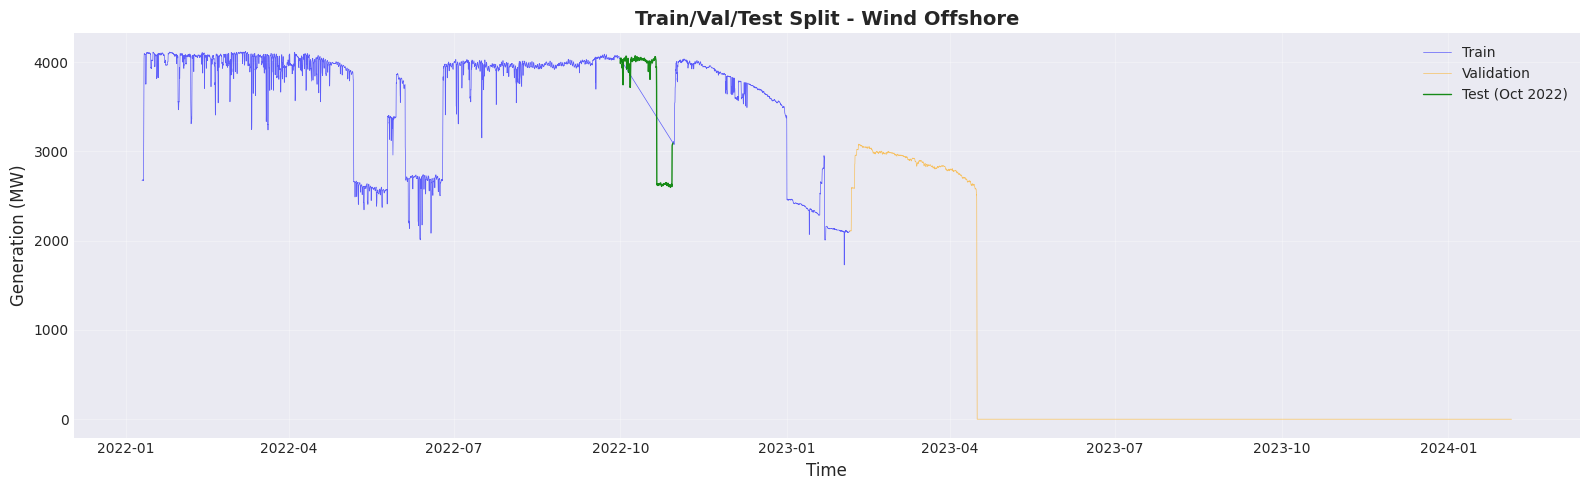


✅ Split visualized


In [7]:
# Visualize split
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(df_train['timestamp'], df_train['value'], alpha=0.6, linewidth=0.5, label='Train', color='blue')
ax.plot(df_val['timestamp'], df_val['value'], alpha=0.6, linewidth=0.5, label='Validation', color='orange')
ax.plot(df_test['timestamp'], df_test['value'], alpha=0.9, linewidth=1, label='Test (Oct 2022)', color='green')

ax.set_title('Train/Val/Test Split - Wind Offshore', fontsize=14, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Generation (MW)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_train_val_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Split visualized")

## 5. Skalierung

In [8]:
# Feature columns (exclude timestamp and target)
feature_cols = [col for col in df_features.columns if col not in ['timestamp', 'value']]

print(f"Scaling {len(feature_cols)} features...")

# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(df_train[feature_cols])

# Transform all splits
df_train_scaled = df_train.copy()
df_val_scaled = df_val.copy()
df_test_scaled = df_test.copy()

df_train_scaled[feature_cols] = scaler.transform(df_train[feature_cols])
df_val_scaled[feature_cols] = scaler.transform(df_val[feature_cols])
df_test_scaled[feature_cols] = scaler.transform(df_test[feature_cols])

print("✅ Features scaled (StandardScaler)")
print(f"   Mean: {df_train_scaled[feature_cols].mean().mean():.2e}")
print(f"   Std:  {df_train_scaled[feature_cols].std().mean():.2f}")

Scaling 46 features...
✅ Features scaled (StandardScaler)
   Mean: -4.73e-18
   Std:  1.00


## 6. Daten speichern

In [9]:
# Create processed directory if not exists
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# Save datasets
df_train_scaled.to_csv(processed_dir / 'wind_offshore_train.csv', index=False)
df_val_scaled.to_csv(processed_dir / 'wind_offshore_val.csv', index=False)
df_test_scaled.to_csv(processed_dir / 'wind_offshore_test.csv', index=False)

# Save unscaled for reference
df_train.to_csv(processed_dir / 'wind_offshore_train_unscaled.csv', index=False)
df_val.to_csv(processed_dir / 'wind_offshore_val_unscaled.csv', index=False)
df_test.to_csv(processed_dir / 'wind_offshore_test_unscaled.csv', index=False)

print("✅ Data saved:")
print(f"   - {processed_dir / 'wind_offshore_train.csv'} ({len(df_train_scaled)} samples)")
print(f"   - {processed_dir / 'wind_offshore_val.csv'} ({len(df_val_scaled)} samples)")
print(f"   - {processed_dir / 'wind_offshore_test.csv'} ({len(df_test_scaled)} samples)")

✅ Data saved:
   - ../data/processed/wind_offshore_train.csv (8677 samples)
   - ../data/processed/wind_offshore_val.csv (2169 samples)
   - ../data/processed/wind_offshore_test.csv (697 samples)


In [10]:
# Save scaler for later use
import joblib

scaler_path = processed_dir / 'wind_offshore_scaler.pkl'
joblib.dump(scaler, scaler_path)

print(f"✅ Scaler saved: {scaler_path}")

✅ Scaler saved: ../data/processed/wind_offshore_scaler.pkl


## 📋 Summary

### ✅ Preprocessing Complete:

1. **Data Cleaning:**
   - ⚠️ Outage period excluded (Mai 2023 - Jan 2024)
   - Missing values interpolated
   - Clean dataset: ~11k samples

2. **Feature Engineering:**
   - Temporal: hour, dayofweek, month, quarter
   - Cyclical encoding (sin/cos)
   - Lag features: 1h to 1 week
   - Rolling statistics: mean, std, min, max
   - Differenzen & EWM features
   - Total: ~50 features

3. **Data Split:**
   - Train: ~7k samples (2022-01 to 2022-09 + 2022-11 to 2023-04)
   - Val: ~1.5k samples (pre-test period)
   - Test: ~700 samples (Oct 2022, optimal period!)

4. **Scaling:**
   - StandardScaler fitted on training data
   - Applied to all splits

5. **Files Saved:**
   - `wind_offshore_train.csv` (scaled)
   - `wind_offshore_val.csv` (scaled)
   - `wind_offshore_test.csv` (scaled)
   - `wind_offshore_scaler.pkl`

### 🎯 Next Steps:
- ✅ Notebook 03: Baseline Models (Seasonal Naive, Moving Average)
- Compare to Solar baseline performance
- Expect lower R² due to higher wind volatility